<a href="https://colab.research.google.com/github/MISJasonChuang/ELM_Pretest/blob/main/ELM_randomness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  --quiet hide code cell output
!pip install -U scikit-multiflow --quiet
!pip install statsmodels --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.6/450.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# -*- coding: utf8
# Author: David C. Lambert [dcl -at- panix -dot- com]
# Copyright(c) 2013
# License: Simple BSD

"""The :mod:`random_layer` module
implements Random Layer transformers.

Random layers are arrays of hidden unit activations that are
random functions of input activation values (dot products for simple
activation functions, distances from prototypes for radial basis
functions).

They are used in the implementation of Extreme Learning Machines (ELMs),
but can be used as a general input mapping.
"""

from abc import ABCMeta, abstractmethod

from math import sqrt

import numpy as np
import scipy.sparse as sp
from scipy.spatial.distance import cdist, pdist, squareform

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.base import BaseEstimator, TransformerMixin

__all__ = [
    "RandomLayer",
    "MLPRandomLayer",
    "RBFRandomLayer",
    "GRBFRandomLayer",
]


class BaseRandomLayer(BaseEstimator, TransformerMixin):
    """Abstract Base Class for random  layers"""

    __metaclass__ = ABCMeta

    _internal_activation_funcs = dict()

    @classmethod
    def activation_func_names(cls):
        """Get list of internal activation function names"""
        return cls._internal_activation_funcs.keys()

    # take n_hidden and random_state, init components_ and
    # input_activations_
    def __init__(
        self, n_hidden=20, random_state=0, activation_func=None, activation_args=None
    ):
        self.n_hidden = n_hidden
        self.random_state = random_state
        self.activation_func = activation_func
        self.activation_args = activation_args

        self.components_ = dict()
        self.input_activations_ = None

        # keyword args for internally defined funcs
        self._extra_args = dict()

    @abstractmethod
    def _generate_components(self, X):
        """Generate components of hidden layer given X"""

    @abstractmethod
    def _compute_input_activations(self, X):
        """Compute input activations given X"""

    # compute input activations and pass them
    # through the hidden layer transfer functions
    # to compute the transform
    def _compute_hidden_activations(self, X):
        """Compute hidden activations given X"""

        self._compute_input_activations(X)

        acts = self.input_activations_

        if callable(self.activation_func):
            args_dict = self.activation_args if (self.activation_args) else {}
            X_new = self.activation_func(acts, **args_dict)
        else:
            func_name = self.activation_func
            func = self._internal_activation_funcs[func_name]

            X_new = func(acts, **self._extra_args)

        return X_new

    # perform fit by generating random components based
    # on the input array
    def fit(self, X, y=None):
        """Generate a random hidden layer.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training set: only the shape is used to generate random component
            values for hidden units

        y : is not used: placeholder to allow for usage in a Pipeline.

        Returns
        -------
        self
        """
        X = check_array(X)

        self._generate_components(X)

        return self

    # perform transformation by calling compute_hidden_activations
    # (which will normally call compute_input_activations first)
    def transform(self, X, y=None):
        """Generate the random hidden layer's activations given X as input.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape [n_samples, n_features]
            Data to transform

        y : is not used: placeholder to allow for usage in a Pipeline.

        Returns
        -------
        X_new : numpy array of shape [n_samples, n_components]
        """
        X = check_array(X)

        if self.components_ is None:
            raise ValueError("No components initialized")

        return self._compute_hidden_activations(X)


class RandomLayer(BaseRandomLayer):
    """RandomLayer is a transformer that creates a feature mapping of the
    inputs that corresponds to a layer of hidden units with randomly
    generated components.

    The transformed values are a specified function of input activations
    that are a weighted combination of dot product (multilayer perceptron)
    and distance (rbf) activations:

      input_activation = alpha * mlp_activation + (1-alpha) * rbf_activation

      mlp_activation(x) = dot(x, weights) + bias
      rbf_activation(x) = rbf_width * ||x - center||/radius

      alpha and rbf_width are specified by the user

      weights and biases are taken from normal distribution of
      mean 0 and sd of 1

      centers are taken uniformly from the bounding hyperrectangle
      of the inputs, and radii are max(||x-c||)/sqrt(n_centers*2)

    The input activation is transformed by a transfer function that defaults
    to numpy.tanh if not specified, but can be any callable that returns an
    array of the same shape as its argument (the input activation array, of
    shape [n_samples, n_hidden]).  Functions provided are 'sine', 'tanh',
    'tribas', 'inv_tribas', 'sigmoid', 'hardlim', 'softlim', 'gaussian',
    'multiquadric', or 'inv_multiquadric'.

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate

    `alpha` : float, optional (default=0.5)
        Mixing coefficient for distance and dot product input activations:
        activation = alpha*mlp_activation + (1-alpha)*rbf_width*rbf_activation

    `rbf_width` : float, optional (default=1.0)
        multiplier on rbf_activation

    `user_components`: dictionary, optional (default=None)
        dictionary containing values for components that woud otherwise be
        randomly generated.  Valid key/value pairs are as follows:
           'radii'  : array-like of shape [n_hidden]
           'centers': array-like of shape [n_hidden, n_features]
           'biases' : array-like of shape [n_hidden]
           'weights': array-like of shape [n_features, n_hidden]

    `activation_func` : {callable, string} optional (default='tanh')
        Function used to transform input activation

        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribas',
        'sigmoid', 'hardlim', 'softlim', 'gaussian', 'multiquadric',
        'inv_multiquadric' or a callable.  If None is given, 'tanh'
        will be used.

        If a callable is given, it will be used to compute the activations.

    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func

    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.

    Attributes
    ----------
    `input_activations_` : numpy array of shape [n_samples, n_hidden]
        Array containing dot(x, hidden_weights) + bias for all samples

    `components_` : dictionary containing two keys:
        `bias_weights_`   : numpy array of shape [n_hidden]
        `hidden_weights_` : numpy array of shape [n_features, n_hidden]

    See Also
    --------
    """

    # triangular activation function
    _tribas = lambda x: np.clip(1.0 - np.fabs(x), 0.0, 1.0)

    # inverse triangular activation function
    _inv_tribas = lambda x: np.clip(np.fabs(x), 0.0, 1.0)

    # sigmoid activation function
    _sigmoid = lambda x: 1.0 / (1.0 + np.exp(-x))

    # hard limit activation function
    _hardlim = lambda x: np.array(x > 0.0, dtype=float)

    _softlim = lambda x: np.clip(x, 0.0, 1.0)

    # gaussian RBF
    _gaussian = lambda x: np.exp(-pow(x, 2.0))

    # multiquadric RBF
    _multiquadric = lambda x: np.sqrt(1.0 + pow(x, 2.0))

    # inverse multiquadric RBF
    _inv_multiquadric = lambda x: 1.0 / (np.sqrt(1.0 + pow(x, 2.0)))

    # internal activation function table
    _internal_activation_funcs = {
        "sine": np.sin,
        "tanh": np.tanh,
        "tribas": _tribas,
        "inv_tribas": _inv_tribas,
        "sigmoid": _sigmoid,
        "softlim": _softlim,
        "hardlim": _hardlim,
        "gaussian": _gaussian,
        "multiquadric": _multiquadric,
        "inv_multiquadric": _inv_multiquadric,
    }

    def __init__(
        self,
        n_hidden=20,
        alpha=0.5,
        random_state=None,
        activation_func="tanh",
        activation_args=None,
        user_components=None,
        rbf_width=1.0,
    ):
        super(RandomLayer, self).__init__(
            n_hidden=n_hidden,
            random_state=random_state,
            activation_func=activation_func,
            activation_args=activation_args,
        )

        if isinstance(self.activation_func, str):
            func_names = self._internal_activation_funcs.keys()
            if self.activation_func not in func_names:
                msg = "unknown activation function '%s'" % self.activation_func
                raise ValueError(msg)

        self.alpha = alpha
        self.rbf_width = rbf_width
        self.user_components = user_components

        self._use_mlp_input = self.alpha != 0.0
        self._use_rbf_input = self.alpha != 1.0

    def _get_user_components(self, key):
        """Look for given user component"""
        try:
            return self.user_components[key]
        except (TypeError, KeyError):
            return None

    def _compute_radii(self):
        """Generate RBF radii"""

        # use supplied radii if present
        radii = self._get_user_components("radii")

        # compute radii
        if radii is None:
            centers = self.components_["centers"]

            n_centers = centers.shape[0]
            max_dist = np.max(pairwise_distances(centers))
            radii = np.ones(n_centers) * max_dist / sqrt(2.0 * n_centers)

        self.components_["radii"] = radii

    def _compute_centers(self, X, sparse, rs):
        """Generate RBF centers"""

        # use supplied centers if present
        centers = self._get_user_components("centers")

        # use points taken uniformly from the bounding
        # hyperrectangle
        if centers is None:
            n_features = X.shape[1]

            if sparse:
                fxr = xrange(n_features)
                cols = [X.getcol(i) for i in fxr]

                min_dtype = X.dtype.type(1.0e10)
                sp_min = lambda col: np.minimum(min_dtype, np.min(col.data))
                min_Xs = np.array(map(sp_min, cols))

                max_dtype = X.dtype.type(-1.0e10)
                sp_max = lambda col: np.maximum(max_dtype, np.max(col.data))
                max_Xs = np.array(map(sp_max, cols))
            else:
                min_Xs = X.min(axis=0)
                max_Xs = X.max(axis=0)

            spans = max_Xs - min_Xs
            ctrs_size = (self.n_hidden, n_features)
            centers = min_Xs + spans * rs.uniform(0.0, 1.0, ctrs_size)

        self.components_["centers"] = centers

    def _compute_biases(self, rs):
        """Generate MLP biases"""

        # use supplied biases if present
        biases = self._get_user_components("biases")
        if biases is None:
            b_size = self.n_hidden
            biases = rs.normal(size=b_size)

        self.components_["biases"] = biases

    def _compute_weights(self, X, rs):
        """Generate MLP weights"""

        # use supplied weights if present
        weights = self._get_user_components("weights")
        if weights is None:
            n_features = X.shape[1]
            hw_size = (n_features, self.n_hidden)
            weights = rs.normal(size=hw_size)

        self.components_["weights"] = weights

    def _generate_components(self, X):
        """Generate components of hidden layer given X"""

        rs = check_random_state(self.random_state)
        if self._use_mlp_input:
            self._compute_biases(rs)
            self._compute_weights(X, rs)

        if self._use_rbf_input:
            self._compute_centers(X, sp.issparse(X), rs)
            self._compute_radii()

    def _compute_input_activations(self, X):
        """Compute input activations given X"""

        n_samples = X.shape[0]

        mlp_acts = np.zeros((n_samples, self.n_hidden))
        if self._use_mlp_input:
            b = self.components_["biases"]
            w = self.components_["weights"]
            mlp_acts = self.alpha * (safe_sparse_dot(X, w) + b)

        rbf_acts = np.zeros((n_samples, self.n_hidden))
        if self._use_rbf_input:
            radii = self.components_["radii"]
            centers = self.components_["centers"]
            scale = self.rbf_width * (1.0 - self.alpha)
            rbf_acts = scale * cdist(X, centers) / radii

        self.input_activations_ = mlp_acts + rbf_acts


class MLPRandomLayer(RandomLayer):
    """Wrapper for RandomLayer with alpha (mixing coefficient) set
    to 1.0 for MLP activations only"""

    def __init__(
        self,
        n_hidden=20,
        random_state=None,
        activation_func="tanh",
        activation_args=None,
        weights=None,
        biases=None,
    ):
        user_components = {"weights": weights, "biases": biases}
        super(MLPRandomLayer, self).__init__(
            n_hidden=n_hidden,
            random_state=random_state,
            activation_func=activation_func,
            activation_args=activation_args,
            user_components=user_components,
            alpha=1.0,
        )


class RBFRandomLayer(RandomLayer):
    """Wrapper for RandomLayer with alpha (mixing coefficient) set
    to 0.0 for RBF activations only"""

    def __init__(
        self,
        n_hidden=20,
        random_state=None,
        activation_func="gaussian",
        activation_args=None,
        centers=None,
        radii=None,
        rbf_width=1.0,
    ):
        user_components = {"centers": centers, "radii": radii}
        super(RBFRandomLayer, self).__init__(
            n_hidden=n_hidden,
            random_state=random_state,
            activation_func=activation_func,
            activation_args=activation_args,
            user_components=user_components,
            rbf_width=rbf_width,
            alpha=0.0,
        )


class GRBFRandomLayer(RBFRandomLayer):
    """Random Generalized RBF Hidden Layer transformer

    Creates a layer of radial basis function units where:

       f(a), s.t. a = ||x-c||/r

    with c the unit center
    and f() is exp(-gamma * a^tau) where tau and r are computed
    based on [1]

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate, ignored if centers are provided

    `grbf_lambda` : float, optional (default=0.05)
        GRBF shape parameter

    `gamma` : {int, float} optional (default=1.0)
        Width multiplier for GRBF distance argument

    `centers` : array of shape (n_hidden, n_features), optional (default=None)
        If provided, overrides internal computation of the centers

    `radii` : array of shape (n_hidden),  optional (default=None)
        If provided, overrides internal computation of the radii

    `use_exemplars` : bool, optional (default=False)
        If True, uses random examples from the input to determine the RBF
        centers, ignored if centers are provided

    `random_state`  : int or RandomState instance, optional (default=None)
        Control the pseudo random number generator used to generate the
        centers at fit time, ignored if centers are provided

    Attributes
    ----------
    `components_` : dictionary containing two keys:
        `radii_`   : numpy array of shape [n_hidden]
        `centers_` : numpy array of shape [n_hidden, n_features]

    `input_activations_` : numpy array of shape [n_samples, n_hidden]
        Array containing ||x-c||/r for all samples

    See Also
    --------
    ELMRegressor, ELMClassifier, SimpleELMRegressor, SimpleELMClassifier,
    SimpleRandomLayer

    References
    ----------
    .. [1] Fernandez-Navarro, et al, "MELM-GRBF: a modified version of the
              extreme learning machine for generalized radial basis function
              neural networks", Neurocomputing 74 (2011), 2502-2510

    """

    # def _grbf(acts, taus):
    #     """GRBF activation function"""

    #     return np.exp(np.exp(-pow(acts, taus)))

    _grbf = lambda acts, taus: np.exp(np.exp(-pow(acts, taus)))

    _internal_activation_funcs = {"grbf": _grbf}

    def __init__(
        self,
        n_hidden=20,
        grbf_lambda=0.001,
        centers=None,
        radii=None,
        random_state=None,
    ):
        super(GRBFRandomLayer, self).__init__(
            n_hidden=n_hidden,
            activation_func="grbf",
            centers=centers,
            radii=radii,
            random_state=random_state,
        )

        self.grbf_lambda = grbf_lambda
        self.dN_vals = None
        self.dF_vals = None
        self.tau_vals = None

    # get centers from superclass, then calculate tau_vals
    # according to ref [1]
    def _compute_centers(self, X, sparse, rs):
        """Generate centers, then compute tau, dF and dN vals"""

        super(GRBFRandomLayer, self)._compute_centers(X, sparse, rs)

        centers = self.components_["centers"]
        sorted_distances = np.sort(squareform(pdist(centers)))
        self.dF_vals = sorted_distances[:, -1]
        self.dN_vals = sorted_distances[:, 1] / 100.0
        # self.dN_vals = 0.0002 * np.ones(self.dF_vals.shape)

        tauNum = np.log(np.log(self.grbf_lambda) / np.log(1.0 - self.grbf_lambda))

        tauDenom = np.log(self.dF_vals / self.dN_vals)

        self.tau_vals = tauNum / tauDenom

        self._extra_args["taus"] = self.tau_vals

    # get radii according to ref [1]
    def _compute_radii(self):
        """Generate radii"""

        denom = pow(-np.log(self.grbf_lambda), 1.0 / self.tau_vals)
        self.components_["radii"] = self.dF_vals / denom

In [3]:
%%capture
# -*- coding: utf8
# Author: David C. Lambert [dcl -at- panix -dot- com]
# Copyright(c) 2013
# License: Simple BSD

"""
The :mod:`elm` module implements the
Extreme Learning Machine Classifiers and Regressors (ELMClassifier,
ELMRegressor, SimpleELMRegressor, SimpleELMClassifier).

An Extreme Learning Machine (ELM) is a single layer feedforward
network with a random hidden layer components and ordinary linear
least squares fitting of the hidden->output weights by default.
[1][2]

References
----------
.. [1] http://www.extreme-learning-machines.org
.. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
          2006.
"""

from abc import ABCMeta, abstractmethod

import numpy as np
from scipy.linalg import pinv

from sklearn.utils import as_float_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import LabelBinarizer

# from random_layer import RandomLayer, MLPRandomLayer

__all__ = ["ELMRegressor",
           "ELMClassifier",
           "GenELMRegressor",
           "GenELMClassifier"]


# BaseELM class, regressor and hidden_layer attributes
# and provides defaults for docstrings
class BaseELM(BaseEstimator):
    """
    Base class for ELMs.

    Warning: This class should not be used directly.
    Use derived classes instead.
    """
    __metaclass__ = ABCMeta

    def __init__(self, hidden_layer, regressor):
        self.regressor = regressor
        self.hidden_layer = hidden_layer

    @abstractmethod
    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """

    @abstractmethod
    def predict(self, X):
        """
        Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """


class GenELMRegressor(BaseELM, RegressorMixin):
    """
    ELMRegressor is a regressor based on the Extreme Learning Machine.

    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]

    Parameters
    ----------
    `hidden_layer` : random_layer instance, optional
        (default=MLPRandomLayer(random_state=0))

    `regressor`    : regressor instance, optional (default=None)
        If provided, this object is used to perform the regression from hidden
        unit activations to the outputs and subsequent predictions.  If not
        present, an ordinary linear least squares fit is performed

    Attributes
    ----------
    `coefs_` : numpy array
        Fitted regression coefficients if no regressor supplied.

    `fitted_` : bool
        Flag set when fit has been called already.

    `hidden_activations_` : numpy array of shape [n_samples, n_hidden]
        Hidden layer activations for last input.

    See Also
    --------
    RBFRandomLayer, MLPRandomLayer, ELMRegressor, ELMClassifier

    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """

    def __init__(self,
                 hidden_layer=MLPRandomLayer(random_state=0),
                 regressor=None):

        super(GenELMRegressor, self).__init__(hidden_layer, regressor)

        self.coefs_ = None
        self.fitted_ = False
        self.hidden_activations_ = None

    def _fit_regression(self, y):
        """
        fit regression using pseudo-inverse
        or supplied regressor
        """
        if (self.regressor is None):
            self.coefs_ = safe_sparse_dot(pinv(self.hidden_activations_), y)
        else:
            self.regressor.fit(self.hidden_activations_, y)

        self.fitted_ = True

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        # fit random hidden layer and compute the hidden layer activations
        self.hidden_activations_ = self.hidden_layer.fit_transform(X)
        # print(self.hidden_activations_)
        # print(f"-------training hidden_activations shape {self.hidden_activations_.shape}------------")

        # solve the regression from hidden activations to outputs
        self._fit_regression(as_float_array(y, copy=True))

        return self

    def _get_predictions(self):
        """get predictions using internal least squares/supplied regressor"""
        if (self.regressor is None):
            preds = safe_sparse_dot(self.hidden_activations_, self.coefs_)
        else:
            preds = self.regressor.predict(self.hidden_activations_)

        return preds

    def predict(self, X):
        """
        Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        if (not self.fitted_):
            raise ValueError("ELMRegressor not fitted")

        # compute hidden layer activations
        self.hidden_activations_ = self.hidden_layer.transform(X)
        # print(self.hidden_activations_)
        # print(f"-------hidden_activations shape {self.hidden_activations_.shape}------------")
        # compute output predictions for new hidden activations
        predictions = self._get_predictions()

        return predictions

'''
class GenELMClassifier(BaseELM, ClassifierMixin):
    """
    GenELMClassifier is a classifier based on the Extreme Learning Machine.

    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]

    Parameters
    ----------
    `hidden_layer` : random_layer instance, optional
        (default=MLPRandomLayer(random_state=0))

    `binarizer` : LabelBinarizer, optional
        (default=LabelBinarizer(-1, 1))

    `regressor`    : regressor instance, optional (default=None)
        If provided, this object is used to perform the regression from hidden
        unit activations to the outputs and subsequent predictions.  If not
        present, an ordinary linear least squares fit is performed

    Attributes
    ----------
    `classes_` : numpy array of shape [n_classes]
        Array of class labels

    `genelm_regressor_` : ELMRegressor instance
        Performs actual fit of binarized values

    See Also
    --------
    RBFRandomLayer, MLPRandomLayer, ELMRegressor, ELMClassifier

    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
              Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """
    def __init__(self,
                 hidden_layer=MLPRandomLayer(random_state=0),
                 binarizer=LabelBinarizer(-1, 1),
                 regressor=None):

        super(GenELMClassifier, self).__init__(hidden_layer, regressor)

        self.binarizer = binarizer

        self.classes_ = None
        self.genelm_regressor_ = GenELMRegressor(hidden_layer, regressor)

    def decision_function(self, X):
        """
        This function return the decision function values related to each
        class on an array of test vectors X.

        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]

        Returns
        -------
        C : array of shape [n_samples, n_classes] or [n_samples,]
            Decision function values related to each class, per sample.
            In the two-class case, the shape is [n_samples,]
        """
        return self.genelm_regressor_.predict(X)

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        self.classes_ = np.unique(y)

        y_bin = self.binarizer.fit_transform(y)

        self.genelm_regressor_.fit(X, y_bin)
        return self

    def predict(self, X):
        """Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        raw_predictions = self.decision_function(X)
        class_predictions = self.binarizer.inverse_transform(raw_predictions)

        return class_predictions
'''

# ELMRegressor with default RandomLayer
class ELMRegressor(BaseEstimator, RegressorMixin):
    """
    ELMRegressor is a regressor based on the Extreme Learning Machine.

    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]

    ELMRegressor is a wrapper for an GenELMRegressor that uses a
    RandomLayer and passes the __init__ parameters through
    to the hidden layer generated by the fit() method.

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate in the SimpleRandomLayer

    `alpha` : float, optional (default=0.5)
        Mixing coefficient for distance and dot product input activations:
        activation = alpha*mlp_activation + (1-alpha)*rbf_width*rbf_activation

    `rbf_width` : float, optional (default=1.0)
        multiplier on rbf_activation

    `activation_func` : {callable, string} optional (default='tanh')
        Function used to transform input activation

        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribase', 'sigmoid',
        'hardlim', 'softlim', 'gaussian', 'multiquadric', 'inv_multiquadric' or
        a callable.  If none is given, 'tanh' will be used. If a callable
        is given, it will be used to compute the hidden unit activations.

    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func

    `user_components`: dictionary, optional (default=None)
        dictionary containing values for components that woud otherwise be
        randomly generated.  Valid key/value pairs are as follows:
           'radii'  : array-like of shape [n_hidden]
           'centers': array-like of shape [n_hidden, n_features]
           'biases' : array-like of shape [n_hidden]
           'weights': array-like of shape [n_hidden, n_features]

    `regressor`    : regressor instance, optional (default=None)
        If provided, this object is used to perform the regression from hidden
        unit activations to the outputs and subsequent predictions.  If not
        present, an ordinary linear least squares fit is performed

    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.

    Attributes
    ----------
    `genelm_regressor_` : GenELMRegressor object
        Wrapped object that actually performs the fit.

    See Also
    --------
    RandomLayer, RBFRandomLayer, MLPRandomLayer,
    GenELMRegressor, GenELMClassifier, ELMClassifier

    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """

    def __init__(self, n_hidden=20, alpha=0.5, rbf_width=1.0,
                 activation_func='tanh', activation_args=None,
                 user_components=None, regressor=None, random_state=None):

        self.n_hidden = n_hidden
        self.alpha = alpha
        self.random_state = random_state
        self.activation_func = activation_func
        self.activation_args = activation_args
        self.user_components = user_components
        self.rbf_width = rbf_width
        self.regressor = regressor

        self._genelm_regressor = None

    def _create_random_layer(self):
        """Pass init params to RandomLayer"""

        return RandomLayer(n_hidden=self.n_hidden,
                           alpha=self.alpha, random_state=self.random_state,
                           activation_func=self.activation_func,
                           activation_args=self.activation_args,
                           user_components=self.user_components,
                           rbf_width=self.rbf_width)

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        rhl = self._create_random_layer()
        self._genelm_regressor = GenELMRegressor(hidden_layer=rhl,
                                                 regressor=self.regressor)
        self._genelm_regressor.fit(X, y)
        return self

    def predict(self, X):
        """
        Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        if (self._genelm_regressor is None):
            raise ValueError("SimpleELMRegressor not fitted")

        return self._genelm_regressor.predict(X)

'''
class ELMClassifier(ELMRegressor):
    """
    ELMClassifier is a classifier based on the Extreme Learning Machine.

    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]

    ELMClassifier is an ELMRegressor subclass that first binarizes the
    data, then uses the superclass to compute the decision function that
    is then unbinarized to yield the prediction.

    The params for the RandomLayer used in the input transform are
    exposed in the ELMClassifier constructor.

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate in the SimpleRandomLayer

    `activation_func` : {callable, string} optional (default='tanh')
        Function used to transform input activation

        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribase', 'sigmoid',
        'hardlim', 'softlim', 'gaussian', 'multiquadric', 'inv_multiquadric' or
        a callable.  If none is given, 'tanh' will be used. If a callable
        is given, it will be used to compute the hidden unit activations.

    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func

    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.

    Attributes
    ----------
    `classes_` : numpy array of shape [n_classes]
        Array of class labels

    See Also
    --------
    RandomLayer, RBFRandomLayer, MLPRandomLayer,
    GenELMRegressor, GenELMClassifier, ELMClassifier

    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """

    def __init__(self, n_hidden=20, alpha=0.5, rbf_width=1.0,
                 activation_func='tanh', activation_args=None,
                 user_components=None, regressor=None,
                 binarizer=LabelBinarizer(-1, 1),
                 random_state=None):

        super(ELMClassifier, self).__init__(n_hidden=n_hidden,
                                            alpha=alpha,
                                            random_state=random_state,
                                            activation_func=activation_func,
                                            activation_args=activation_args,
                                            user_components=user_components,
                                            rbf_width=rbf_width,
                                            regressor=regressor)

        self.classes_ = None
        self.binarizer = binarizer

    def decision_function(self, X):
        """
        This function return the decision function values related to each
        class on an array of test vectors X.

        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]

        Returns
        -------
        C : array of shape [n_samples, n_classes] or [n_samples,]
            Decision function values related to each class, per sample.
            In the two-class case, the shape is [n_samples,]
        """
        return super(ELMClassifier, self).predict(X)

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        self.classes_ = np.unique(y)

        y_bin = self.binarizer.fit_transform(y)

        super(ELMClassifier, self).fit(X, y_bin)

        return self

    def predict(self, X):
        """
        Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        raw_predictions = self.decision_function(X)
        class_predictions = self.binarizer.inverse_transform(raw_predictions)

        return class_predictions

    def score(self, X, y):
        """Force use of accuracy score since we don't inherit
           from ClassifierMixin"""

        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X))
'''

In [4]:
%%capture
# hide code cell output
from google.colab import drive
drive.mount('/content/drive')

In [17]:
# from elm import ELMRegressor
from collections.abc import Iterable
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pylab as py
import random
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from skmultiflow.drift_detection import DDM
import statsmodels.api as sm
import sys
from typing import Union

sc = preprocessing.StandardScaler()

'''
    (Cavalcante & Oliveira, 2015)
    Feature Selection:
    The input data is composed by daily open, high, low and close prices and two classical technical indicators,
    the exponential moving average (EMA) and the Bollinger Bands (BB):
    1) lowest and highest prices of the 5 previous days;
    2) opening and closing prices of the 5 previous days;
    3) EMA of the lowest and highest prices of the 5 previous days;
    4) EMA of the opening and closing prices of the 5 previous days;
    5) BB of the opening and closing prices of the 5 previous days;
    6) BB of the lowest and highest prices of the 5 previous days;
'''

'''
    (Mishra & Das, 2022)
    Feature Selection:
    The available features for the GOLD/USD dataset are price, open price, high price, low price, volume, and price change.
    The gold data available for predictions are in 1 Troy Ounce Unit.
    This experimentation has worked out for four time horizons such as 1 day, 3 days, 7 days, and 1 month in advance.
    A total of 70% of data is selected for training and 30% is selected for testing .
'''
def handle_datasets(train_split: float = 0.8, show_fig: bool = False) -> list:
    # reverse dataframe datetime
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/gold prices 2013-2023.csv', parse_dates=['Date'], index_col='Date')
    df= df.sort_values(by='Date')
    df = df.rename(columns={"Close/Last": "close"})
    df.columns = df.columns.str.lower()
    # replace Nan
    df['volume'] = df['volume'].interpolate()
    # 5 days average
    #  moving_avg = df['close'].rolling(window=5).mean()
    # df['moving_average'] = moving_avg

    # 1) lowest and highest prices of the 5 previous days;
    df['high_previous_1_days'] = df['high'].shift(1)
    df['low_previous_1_days'] = df['low'].shift(1)


    # 2) opening and closing prices of the 5 previous days;
    df['close_previous_1_days'] = df['close'].shift(1)
    df['open_previous_1_days'] = df['open'].shift(1)

    # change = yesterday - the day before yesterday
    df['change'] = df['close'].diff()
    df['change'] = df['change'].shift(1)

    # exclude 5 columns, others = input features, start from index=5 drop NaN
    x = df[df.columns.difference(['close', 'open', 'high', 'low'])][2:]
    y = df["close"][2:]

    if show_fig:
        plt.title("Gold prices")
        plt.plot(y[:50], color="green")
        plt.plot(x.drop(columns=['volume','change'])[:50], color="orange")
        plt.xlabel("Days")
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Close price")
        plt.show(block=False)
    # 2d-array x.shape = (input_samples, features)
    x_train, x_test = to_ndarray(x, split = train_split,features = x.shape[1])
    y_train, y_test = to_ndarray(y, split = train_split)
    res = [x_train, y_train, x_test, y_test]
    return res


def to_ndarray(df: Union[pd.DataFrame, pd.Series], split: float = 0.8, features: int = 1):
    nd = df.to_numpy()
    train_set, test_set = np.split(nd, [int(split * len(nd))])
    train_set = train_set.reshape(-1, features)
    test_set = test_set.reshape(-1, features)
    train_set = sc.fit_transform(train_set)
    test_set = sc.fit_transform(test_set)
    return train_set, test_set

In [6]:
def plot_fig(x:Iterable, y:Iterable, x_label: str, y_label:str, show: bool=False, color:str="black", clean: bool = True):
    if show:
        plt.plot(x, y, color=color)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
    if clean:
        plt.show(block=False)
        plt.clf()

In [7]:
def drift_detection(data_stream: list, retrain_data: list, nodes: int, warning_level: float = 2.0, drift_detect: float = 3.0, threshold_opt: int = 0) -> None:
    '''
        prediction: int (either 0 or 1)
            This parameter indicates whether the last sample analyzed was
            correctly classified or not. 1 indicates an error (miss-classification).
    '''
    ddm = DDM(min_num_instances=30, warning_level=warning_level, out_control_level=drift_detect)
    warning_status = False
    warning_start = 0
    warning_end = 0
    for i in range(len(data_stream)):
        ddm.add_element(data_stream[i])
        if ddm.detected_change() and warning_status:
            warning_end = i
            assert warning_end > warning_start
            print(f"warning start at index {warning_start}, Change has been detected in index {warning_end}")
            # retrain
            warning_status = False
            # at least 30 data samples
            if warning_end-warning_start>=30:
                # retrain immediately
                break
        elif ddm.detected_warning_zone():
            if not warning_status:
                warning_start = i
            warning_status = True
            # print('Warning zone has been detected in data: ' + str(data_stream[i]) + ' - of index: ' + str(i))
        else:
            warning_status = False
    if warning_end-warning_start>=30:
        print(f"-------------------retrain with data from index {warning_start}~{warning_end}-------------------")
        print(f"-------------------testing with data from index {warning_end+1}~{len(data_stream)}-------------------")
        x_train = retrain_data[0][warning_start:warning_end]
        y_train = retrain_data[1][warning_start:warning_end]
        x_test = retrain_data[0][warning_end:]
        y_test = retrain_data[1][warning_end:]
        datasets = [x_train, y_train, x_test, y_test]
        # enable the network to perform feature extraction
        train(datasets, nodes=nodes+3, show_fig=True, threshold_opt=threshold_opt, level_config=(warning_level, drift_detect))

In [8]:
def train(datasets: list[np.ndarray],nodes: int = 20, random_state: int = 0, show_fig: bool = False, threshold_opt: int = 0, level_config: tuple = (1.0, 2.0)) -> dict:
    print(f"hidden nodes {nodes} ,threshold option {threshold_opt}")
    # option: random_state=1
    elmr = ELMRegressor(n_hidden=nodes, random_state=random_state)
    x_train, y_train, x_test, y_test = (
        datasets[0],
        datasets[1],
        datasets[2],
        datasets[3],
    )
    elmr = elmr.fit(x_train, y_train)
    # Inverse Transform the Predictions(real world value)
    res = elmr.predict(x_test)

    y_pred = sc.inverse_transform(elmr.predict(x_test))
    y_actual = sc.inverse_transform(y_test)
    # squared=True -> MSE
    rms = mean_squared_error(y_actual, y_pred, squared=False)
    # threshold 1: compare with previous price difference
    y_prev = np.insert(y_actual, 0, y_actual[0], axis=0)
    y_prev = y_prev[:-1]
    abs_residual = abs(y_actual - y_pred)

    # Residual = actual y - predicted y
    residual = y_actual - y_pred
    res_avg = np.mean(residual)
    res_std = np.std(residual)
    r2 = r2_score(y_true=y_actual, y_pred=y_pred)
    # n: observations, p: predictors(features)
    n = np.shape(x_test)[0]
    p = np.shape(x_test)[1]
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    print(f"Random state = {random_state}, Residual AVG = {res_avg}, Residual STD = {res_std}, RMSE = {rms}")
    print(f"R2 score = {r2}, Adjusted R2 score {adj_r2}")

    prev_abs_residual = abs(y_prev - y_actual)
    bin = abs_residual - prev_abs_residual
    # if y prediction errors > naive errors, prediction errors, return 1
    error_rates = np.where(bin>0, 1, 0)
    error_rates = list(error_rates)
    count_errors = []
    '''
        concept change detection method based on the PAC learning model premise,
        that the learner’s error rate will decrease as the number of analysed samples increase,
        as long as the data distribution is stationary.
    '''
    for index in range(len(error_rates)):
        err_num = error_rates[:index].count(1) / (index+1)
        count_errors.append(err_num)

    # threshold 2: compare with price going up or down predicitons
    y_trend = np.subtract(y_actual, y_prev)
    trend = np.where(y_trend>0, 1, 0)
    y_prev_pred = np.insert(y_pred, 0, y_actual[0], axis=0)
    y_prev_pred = y_prev_pred[:-1]
    y_pred_trend = np.subtract(y_pred, y_prev_pred)
    pred_trend = np.where(y_pred_trend>0, 1, 0)
    trend_result = list()
    for index in range(len(pred_trend)):
        if pred_trend[index] == trend[index]:
            trend_result.append(0)
        else:
            trend_result.append(1)
    count_trend_errors = []
    '''
        concept change detection method based on the PAC learning model premise,
        that the learner’s error rate will decrease as the number of analysed samples increase,
        as long as the data distribution is stationary.
    '''
    for index in range(len(trend_result)):
        err_num = trend_result[:index].count(1) / (index+1)
        count_trend_errors.append(err_num)


    # errors frequency
    stat = np.array(np.unique(residual.astype(int), return_counts=True)).T
    error_list = list()
    freq = list()
    for pair in stat:
        error_list.append(pair[0])
        freq.append(pair[1])
    size = [i*100 for i in freq]
    plt.clf()
    if threshold_opt==0:
        print("-------------threshold 1---------------")
        plot_fig(x=range(len(error_rates)), y=count_errors, x_label="Number of examples", y_label="T1 Errors Rates", show=show_fig, color="red")
    elif threshold_opt==1:
        print("-------------threshold 2---------------")
        plot_fig(x=range(len(count_trend_errors)), y=count_trend_errors, x_label="Number of examples", y_label="T2 Errors Rates", show=show_fig, color="blue")
    plt.clf()
    if show_fig:
        plt.clf()
        # 取誤差範圍 range=-100~100, bins=? 分?組 每組差5
        plt.hist(residual, bins=40, range=(-100,100), facecolor="blue", edgecolor="black", alpha=0.7, density=True)
        # 顯示常態分佈曲線
        mu = 0
        sigma = 20
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 10000)
        plt.plot(x, stats.norm.pdf(x, mu, sigma), color="#FF0000")
        plt.xlabel("residual")
        plt.ylabel("Probability")
        plt.show(block=False)
    DDM_data = error_rates if threshold_opt==0 else trend_result
    # implement DDM
    # drift_detection(data_stream=DDM_data, retrain_data=[x_test, y_test],nodes=nodes, warning_level=level_config[0], drift_detect=level_config[1], threshold_opt=threshold_opt)
    return {"residual":residual, "RMSE":rms}

hidden nodes 60 ,threshold option 1
Random state = 2002819886, Residual AVG = 0.9481479412385582, Residual STD = 21.931621067310854, RMSE = 21.95210666789382
R2 score = 0.9489690689334666, Adjusted R2 score 0.9483579200584182
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 0
hidden nodes 60 ,threshold option 1
Random state = 3541028550, Residual AVG = 0.21753983992567558, Residual STD = 18.122957195593724, RMSE = 18.124262773842066
R2 score = 0.9652142169671547, Adjusted R2 score 0.9647976207631686
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 1
hidden nodes 60 ,threshold option 1
Random state = 2002788137, Residual AVG = -0.11924181659157322, Residual STD = 18.789970848904183, RMSE = 18.790349201478218
R2 score = 0.962610402859538, Adjusted R2 score 0.9621626232530655
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 2
hidden nodes 60 ,threshold option 1
Random state = 1065110717, Residual AVG = -1.0735790147777278, Residual STD = 19.47190333343231, RMSE = 19.501476644795478
R2 score = 0.9597268056438065, Adjusted R2 score 0.9592444919389419
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 3
hidden nodes 60 ,threshold option 1
Random state = 2496476467, Residual AVG = -0.999729415771047, Residual STD = 17.648144018203567, RMSE = 17.676437599018993
R2 score = 0.9669119957836971, Adjusted R2 score 0.9665157322601486
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 4
hidden nodes 60 ,threshold option 1
Random state = 3867331466, Residual AVG = -1.415510130051655, Residual STD = 19.47063860361312, RMSE = 19.522024397095407
R2 score = 0.9596418931422944, Adjusted R2 score 0.9591585625212441
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 5
hidden nodes 60 ,threshold option 1
Random state = 2544715275, Residual AVG = -3.2814959243182096, Residual STD = 21.49225069774086, RMSE = 21.74132138477005
R2 score = 0.9499443672811783, Adjusted R2 score 0.949344898625863
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 6
hidden nodes 60 ,threshold option 1
Random state = 138966878, Residual AVG = -2.752505240058674, Residual STD = 19.471423303089004, RMSE = 19.66500980281037
R2 score = 0.9590485373429135, Adjusted R2 score 0.9585581006643855
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 7
hidden nodes 60 ,threshold option 1
Random state = 1392886553, Residual AVG = -4.039071892019228, Residual STD = 21.443693547050483, RMSE = 21.820772091947486
R2 score = 0.9495778557919248, Adjusted R2 score 0.9489739977774568
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 8
hidden nodes 60 ,threshold option 1
Random state = 613517616, Residual AVG = -1.5589166864053403, Residual STD = 17.556524630956492, RMSE = 17.62560008489172
R2 score = 0.9671020445977421, Adjusted R2 score 0.9667080571078946
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 9
hidden nodes 60 ,threshold option 1
Random state = 1234258325, Residual AVG = 2.7108617746126136, Residual STD = 21.559426008834603, RMSE = 21.729188235906783
R2 score = 0.9500002206459203, Adjusted R2 score 0.9494014208931768
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 10
hidden nodes 60 ,threshold option 1
Random state = 3441551711, Residual AVG = -0.4337627997643403, Residual STD = 17.590045305886257, RMSE = 17.59539269324759
R2 score = 0.9672147113831212, Adjusted R2 score 0.9668220731960927
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 11
hidden nodes 60 ,threshold option 1
Random state = 3622324127, Residual AVG = -2.74603525763724, Residual STD = 19.196733456080903, RMSE = 19.3921449308735
R2 score = 0.9601771094565341, Adjusted R2 score 0.9597001886117021
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 12
hidden nodes 60 ,threshold option 1
Random state = 973514482, Residual AVG = -2.0982353773665645, Residual STD = 18.34952967370418, RMSE = 18.469104768368794
R2 score = 0.9638779180712257, Adjusted R2 score 0.9634453182876476
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 13
hidden nodes 60 ,threshold option 1
Random state = 2123941491, Residual AVG = -2.5028954235146204, Residual STD = 19.105130189025676, RMSE = 19.2683804467493
R2 score = 0.9606838024174885, Adjusted R2 score 0.9602129497518297
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 14
hidden nodes 60 ,threshold option 1
Random state = 2029331889, Residual AVG = -0.5812747890867506, Residual STD = 19.10904630191573, RMSE = 19.117885106600756
R2 score = 0.9612955608998817, Adjusted R2 score 0.9608320346831137
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 15
hidden nodes 60 ,threshold option 1
Random state = 2365169486, Residual AVG = 2.633245093850249, Residual STD = 28.794989116678472, RMSE = 28.915140981048626
R2 score = 0.9114615913735127, Adjusted R2 score 0.910401251150441
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 16
hidden nodes 60 ,threshold option 1
Random state = 3797658309, Residual AVG = -2.4446065158881867, Residual STD = 19.345533107095047, RMSE = 19.499378252017
R2 score = 0.9597354721089246, Adjusted R2 score 0.9592532621940615
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 17
hidden nodes 60 ,threshold option 1
Random state = 91247657, Residual AVG = -1.7562631903948729, Residual STD = 18.82234703027223, RMSE = 18.904105589049536
R2 score = 0.9621563208018052, Adjusted R2 score 0.9617031030868568
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 18
hidden nodes 60 ,threshold option 1
Random state = 1460872673, Residual AVG = -2.7223764713617173, Residual STD = 19.547212846832835, RMSE = 19.73587757692093
R2 score = 0.9587528478593499, Adjusted R2 score 0.958258869989402
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 19
hidden nodes 60 ,threshold option 1
Random state = 149448542, Residual AVG = -1.89196216719029, Residual STD = 19.641498345908243, RMSE = 19.732409333743192
R2 score = 0.9587673435496182, Adjusted R2 score 0.9582735392807514
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 20
hidden nodes 60 ,threshold option 1
Random state = 233482952, Residual AVG = -0.2416336743326467, Residual STD = 19.351006341089683, RMSE = 19.352514907511754
R2 score = 0.960339708229608, Adjusted R2 score 0.9598647346754716
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 21
hidden nodes 60 ,threshold option 1
Random state = 3928689427, Residual AVG = -1.223330658071495, Residual STD = 19.48845807674846, RMSE = 19.52681582102315
R2 score = 0.9596220799789311, Adjusted R2 score 0.9591385120744872
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 22
hidden nodes 60 ,threshold option 1
Random state = 621768726, Residual AVG = -4.799711468538443, Residual STD = 25.377104316530016, RMSE = 25.827014029369828
R2 score = 0.9293634498435085, Adjusted R2 score 0.9285175031350476
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 23
hidden nodes 60 ,threshold option 1
Random state = 2445125670, Residual AVG = -0.8492886470208597, Residual STD = 20.26225723040853, RMSE = 20.280048305593386
R2 score = 0.9564469018716169, Adjusted R2 score 0.9559253078820553
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 24
hidden nodes 60 ,threshold option 1
Random state = 1585859305, Residual AVG = -0.8225112066573173, Residual STD = 17.559572758042226, RMSE = 17.578825903058927
R2 score = 0.9672764197302517, Adjusted R2 score 0.9668845205653446
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 25
hidden nodes 60 ,threshold option 1
Random state = 1983807622, Residual AVG = -2.989279724280252, Residual STD = 20.095761752001987, RMSE = 20.31687558812179
R2 score = 0.9562885789175183, Adjusted R2 score 0.9557650888446741
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 26
hidden nodes 60 ,threshold option 1
Random state = 3809226671, Residual AVG = 0.5535909777990446, Residual STD = 17.63439053398912, RMSE = 17.643077749529574
R2 score = 0.9670367685781145, Adjusted R2 score 0.966641999339529
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 27
hidden nodes 60 ,threshold option 1
Random state = 90928505, Residual AVG = -1.9113476027900007, Residual STD = 19.91436480416028, RMSE = 20.005878516372853
R2 score = 0.9576165467977419, Adjusted R2 score 0.9571089605318466
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 28
hidden nodes 60 ,threshold option 1
Random state = 3475676218, Residual AVG = 1.2880119897692814, Residual STD = 19.52877590393216, RMSE = 19.571204949920453
R2 score = 0.9594382939563973, Adjusted R2 score 0.9589525250217434
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 29
hidden nodes 60 ,threshold option 1
Random state = 3344982172, Residual AVG = -1.9947881518535573, Residual STD = 19.838051448348928, RMSE = 19.93809080724918
R2 score = 0.9579032834829266, Adjusted R2 score 0.957399131189309
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 30
hidden nodes 60 ,threshold option 1
Random state = 1425930066, Residual AVG = -1.6474580203107785, Residual STD = 18.856736585258076, RMSE = 18.928566574743495
R2 score = 0.9620583217092551, Adjusted R2 score 0.9616039303524797
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 31
hidden nodes 60 ,threshold option 1
Random state = 145350094, Residual AVG = -2.2259100678012533, Residual STD = 18.17331633688487, RMSE = 18.30912620281005
R2 score = 0.9645009835904059, Adjusted R2 score 0.9640758456693329
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 32
hidden nodes 60 ,threshold option 1
Random state = 378952287, Residual AVG = -0.591309278614223, Residual STD = 18.254311778670704, RMSE = 18.26388636560936
R2 score = 0.9646761951890488, Adjusted R2 score 0.9642531556104745
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 33
hidden nodes 60 ,threshold option 1
Random state = 1478734373, Residual AVG = -0.8617493239374898, Residual STD = 18.71652958861157, RMSE = 18.736357483211066
R2 score = 0.9628249628223413, Adjusted R2 score 0.9623797527962615
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 34
hidden nodes 60 ,threshold option 1
Random state = 3760485582, Residual AVG = -2.148103403335604, Residual STD = 20.419826884140505, RMSE = 20.532502969917946
R2 score = 0.9553558177719449, Adjusted R2 score 0.9548211569069383
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 35
hidden nodes 60 ,threshold option 1
Random state = 511699616, Residual AVG = -4.509803162716458, Residual STD = 20.11772324431515, RMSE = 20.617010285230627
R2 score = 0.9549875700313142, Adjusted R2 score 0.9544484990137251
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 36
hidden nodes 60 ,threshold option 1
Random state = 1448833041, Residual AVG = -1.18910522422407, Residual STD = 18.821226618715794, RMSE = 18.858752415452432
R2 score = 0.9623376858607554, Adjusted R2 score 0.9618866401824411
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 37
hidden nodes 60 ,threshold option 1
Random state = 2486200358, Residual AVG = 2.3422523850727357, Residual STD = 24.357482552869282, RMSE = 24.469840672728346
R2 score = 0.9365921004888937, Adjusted R2 score 0.9358327244468445
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 38
hidden nodes 60 ,threshold option 1
Random state = 966902476, Residual AVG = 0.29258252989430905, Residual STD = 18.350808907815736, RMSE = 18.353141205471303
R2 score = 0.9643300996945041, Adjusted R2 score 0.9639029152597077
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 39
hidden nodes 60 ,threshold option 1
Random state = 1212183078, Residual AVG = -0.6146213886860288, Residual STD = 18.153358142402606, RMSE = 18.163759833739416
R2 score = 0.9650624388518974, Adjusted R2 score 0.964644024945932
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 40
hidden nodes 60 ,threshold option 1
Random state = 3632358204, Residual AVG = 1.3565227952182444, Residual STD = 20.438613931615254, RMSE = 20.48358107215542
R2 score = 0.9555683078096274, Adjusted R2 score 0.9550361917354913
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 41
hidden nodes 60 ,threshold option 1
Random state = 326784455, Residual AVG = -0.16840690694494326, Residual STD = 18.50705439681934, RMSE = 18.507820599226072
R2 score = 0.96372631763042, Adjusted R2 score 0.9632919022727006
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 42
hidden nodes 60 ,threshold option 1
Random state = 3597065251, Residual AVG = 0.06387637127073865, Residual STD = 19.140929818935128, RMSE = 19.1410364015172
R2 score = 0.961201763868321, Adjusted R2 score 0.9607371143338099
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 43
hidden nodes 60 ,threshold option 1
Random state = 3414459329, Residual AVG = -1.6005843163186826, Residual STD = 17.6470578189217, RMSE = 17.719495473009687
R2 score = 0.9667506019152794, Adjusted R2 score 0.9663524055310313
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 44
hidden nodes 60 ,threshold option 1
Random state = 1680335734, Residual AVG = 0.54149345470692, Residual STD = 17.419599030887195, RMSE = 17.42801324185797
R2 score = 0.9678354969361039, Adjusted R2 score 0.9674502933065962
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 45
hidden nodes 60 ,threshold option 1
Random state = 3048316451, Residual AVG = 0.7584072491104012, Residual STD = 18.80584215927087, RMSE = 18.821128576015646
R2 score = 0.962487811102006, Adjusted R2 score 0.9620385633307725
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 46
hidden nodes 60 ,threshold option 1
Random state = 2331032232, Residual AVG = -2.0594137770958993, Residual STD = 18.936095122364982, RMSE = 19.047752717539865
R2 score = 0.961579008145838, Adjusted R2 score 0.961118876506866
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 47
hidden nodes 60 ,threshold option 1
Random state = 3947360830, Residual AVG = 0.5587932136999608, Residual STD = 18.178384414157325, RMSE = 18.186970879301345
R2 score = 0.9649730900089247, Adjusted R2 score 0.9645536060569359
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 48
hidden nodes 60 ,threshold option 1
Random state = 1615600857, Residual AVG = 2.196165696088659, Residual STD = 18.526689875634045, RMSE = 18.65640323086413
R2 score = 0.9631415622901127, Adjusted R2 score 0.9627001438744255
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 49
hidden nodes 60 ,threshold option 1
Random state = 1303209305, Residual AVG = -3.5811194174806964, Residual STD = 18.268595473299044, RMSE = 18.616283110473464
R2 score = 0.9632999181014497, Adjusted R2 score 0.9628603961625448
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 50
hidden nodes 60 ,threshold option 1
Random state = 2202129011, Residual AVG = 1.0164649743891074, Residual STD = 21.550603503499538, RMSE = 21.574561696804093
R2 score = 0.9507092931177392, Adjusted R2 score 0.9501189852508858
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 51
hidden nodes 60 ,threshold option 1
Random state = 514732052, Residual AVG = -1.543062220591643, Residual STD = 17.91708058220127, RMSE = 17.983403949355946
R2 score = 0.9657528147589373, Adjusted R2 score 0.9653426688279065
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 52
hidden nodes 60 ,threshold option 1
Random state = 525805178, Residual AVG = 4.288865695535757, Residual STD = 25.759485561974657, RMSE = 26.1140855741097
R2 score = 0.9277844489735745, Adjusted R2 score 0.9269195920750544
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 53
hidden nodes 60 ,threshold option 1
Random state = 3965205847, Residual AVG = -0.021455019913335448, Residual STD = 20.063235275457945, RMSE = 20.063246747130925
R2 score = 0.957373123354352, Adjusted R2 score 0.9568626218376376
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 54
hidden nodes 60 ,threshold option 1
Random state = 2054138773, Residual AVG = -3.127974093923246, Residual STD = 17.762066098887495, RMSE = 18.035387825979882
R2 score = 0.9655545347693502, Adjusted R2 score 0.9651420142276658
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 55
hidden nodes 60 ,threshold option 1
Random state = 2117250076, Residual AVG = 0.472276128313308, Residual STD = 21.18689930951361, RMSE = 21.192162397755517
R2 score = 0.95244111872075, Adjusted R2 score 0.9518715512802799
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 56
hidden nodes 60 ,threshold option 1
Random state = 2556667059, Residual AVG = -2.814241161076387, Residual STD = 19.36358802574409, RMSE = 19.567025694863194
R2 score = 0.9594556152829129, Adjusted R2 score 0.9589700537892951
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 57
hidden nodes 60 ,threshold option 1
Random state = 2005613901, Residual AVG = 3.0457537680850653, Residual STD = 25.59527843872511, RMSE = 25.775858751391212
R2 score = 0.9296429907778233, Adjusted R2 score 0.9288003918649829
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 58
hidden nodes 60 ,threshold option 1
Random state = 1126265731, Residual AVG = -1.8351661305465188, Residual STD = 19.146065283838187, RMSE = 19.233815289216512
R2 score = 0.9608247329593048, Adjusted R2 score 0.9603555680845659
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 59
hidden nodes 60 ,threshold option 1
Random state = 2741399141, Residual AVG = -0.5185813169046726, Residual STD = 18.699884282620147, RMSE = 18.70707349548899
R2 score = 0.9629410774506605, Adjusted R2 score 0.9624972580189318
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 60
hidden nodes 60 ,threshold option 1
Random state = 3117594764, Residual AVG = -0.586212893284372, Residual STD = 21.462671774082576, RMSE = 21.470675938084803
R2 score = 0.9511828391577398, Adjusted R2 score 0.9505982025009463
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 61
hidden nodes 60 ,threshold option 1
Random state = 2619756935, Residual AVG = -1.170445548986755, Residual STD = 19.030757145703575, RMSE = 19.066716034018302
R2 score = 0.9615024687116488, Adjusted R2 score 0.9610414204327464
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 62
hidden nodes 60 ,threshold option 1
Random state = 114377215, Residual AVG = -0.22268847939108216, Residual STD = 18.50620718892288, RMSE = 18.507546965446135
R2 score = 0.9637273902182368, Adjusted R2 score 0.9632929877058803
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 63
hidden nodes 60 ,threshold option 1
Random state = 1025103972, Residual AVG = -2.7448896775329477, Residual STD = 18.448796430878804, RMSE = 18.65187682486225
R2 score = 0.9631594452670988, Adjusted R2 score 0.9627182410188007
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 64
hidden nodes 60 ,threshold option 1
Random state = 502645965, Residual AVG = -0.4574231916959625, Residual STD = 18.243631287450942, RMSE = 18.24936488014748
R2 score = 0.9647323442675834, Adjusted R2 score 0.9643099771330634
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 65
hidden nodes 60 ,threshold option 1
Random state = 3644605228, Residual AVG = 0.649741193957753, Residual STD = 22.120646845444085, RMSE = 22.13018708642069
R2 score = 0.9481377619372992, Adjusted R2 score 0.9475166572898417
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 66
hidden nodes 60 ,threshold option 1
Random state = 3094180186, Residual AVG = -1.591403556685046, Residual STD = 18.919381622773834, RMSE = 18.986194096458146
R2 score = 0.9618269451569174, Adjusted R2 score 0.9613697828234673
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 67
hidden nodes 60 ,threshold option 1
Random state = 2604298607, Residual AVG = -3.2410491949244515, Residual STD = 19.014088140042215, RMSE = 19.28833708957863
R2 score = 0.9606023191150799, Adjusted R2 score 0.960130490601488
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 68
hidden nodes 60 ,threshold option 1
Random state = 598262076, Residual AVG = -3.1500835419240234, Residual STD = 19.275693986474288, RMSE = 19.53139536698035
R2 score = 0.959603138414112, Adjusted R2 score 0.9591193436645804
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 69
hidden nodes 60 ,threshold option 1
Random state = 2737299943, Residual AVG = -2.9086947749254883, Residual STD = 18.445349326994034, RMSE = 18.673280833547118
R2 score = 0.9630748438080761, Adjusted R2 score 0.9626326263686519
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 70
hidden nodes 60 ,threshold option 1
Random state = 3507147384, Residual AVG = -1.4093160811361096, Residual STD = 19.04458583198577, RMSE = 19.096659952159747
R2 score = 0.9613814544664214, Adjusted R2 score 0.9609189569151211
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 71
hidden nodes 60 ,threshold option 1
Random state = 43078647, Residual AVG = -3.9416374519681296, Residual STD = 20.92860838905235, RMSE = 21.29655265307205
R2 score = 0.9519714251228724, Adjusted R2 score 0.9513962326093738
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 72
hidden nodes 60 ,threshold option 1
Random state = 456834008, Residual AVG = -2.7506534463778793, Residual STD = 18.70275345087666, RMSE = 18.903943531082327
R2 score = 0.9621569696390017, Adjusted R2 score 0.9617037596945586
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 73
hidden nodes 60 ,threshold option 1
Random state = 1717440669, Residual AVG = 2.7112136442232537, Residual STD = 20.19633043252675, RMSE = 20.37749843244819
R2 score = 0.9560273316451317, Adjusted R2 score 0.9555007128624387
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 74
hidden nodes 60 ,threshold option 1
Random state = 1161653287, Residual AVG = 0.10065517715466286, Residual STD = 19.444008420168956, RMSE = 19.444268947643398
R2 score = 0.9599627423825466, Adjusted R2 score 0.9594832542673676
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 75
hidden nodes 60 ,threshold option 1
Random state = 3402880451, Residual AVG = 1.2520200913814312, Residual STD = 20.417985005791774, RMSE = 20.456335595750293
R2 score = 0.9556864275392238, Adjusted R2 score 0.9551557260726278
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 76
hidden nodes 60 ,threshold option 1
Random state = 3984542633, Residual AVG = -1.6787104795562613, Residual STD = 17.96406003838285, RMSE = 18.042325846098546
R2 score = 0.9655280280703832, Adjusted R2 score 0.9651151900832021
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 77
hidden nodes 60 ,threshold option 1
Random state = 1471601455, Residual AVG = -0.9216402292301599, Residual STD = 20.867715106185837, RMSE = 20.888057699677873
R2 score = 0.953796252639679, Adjusted R2 score 0.9532429143479386
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 78
hidden nodes 60 ,threshold option 1
Random state = 1080983910, Residual AVG = 2.7148114872242157, Residual STD = 21.564616878237096, RMSE = 21.734831550217102
R2 score = 0.9499742462645564, Adjusted R2 score 0.9493751354413774
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 79
hidden nodes 60 ,threshold option 1
Random state = 2750061800, Residual AVG = -4.207094748294078, Residual STD = 22.416622330278145, RMSE = 22.807994276556812
R2 score = 0.9449122195924825, Adjusted R2 score 0.9442524856953864
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 80
hidden nodes 60 ,threshold option 1
Random state = 798797370, Residual AVG = -2.589174307240713, Residual STD = 21.72572693376141, RMSE = 21.87946604452772
R2 score = 0.9493062379814892, Adjusted R2 score 0.9486991270591117
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 81
hidden nodes 60 ,threshold option 1
Random state = 2119123789, Residual AVG = 0.23818028090181587, Residual STD = 17.55126180328008, RMSE = 17.552877847620564
R2 score = 0.9673729547995222, Adjusted R2 score 0.9669822117432291
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 82
hidden nodes 60 ,threshold option 1
Random state = 3434953195, Residual AVG = 5.460023082095891, Residual STD = 29.982036901691835, RMSE = 30.475143786886896
R2 score = 0.901650397205774, Adjusted R2 score 0.9004725576513521
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 83
hidden nodes 60 ,threshold option 1
Random state = 1436722738, Residual AVG = -0.008804295098395493, Residual STD = 25.77952697109235, RMSE = 25.779528474525872
R2 score = 0.9296229558198188, Adjusted R2 score 0.9287801169673615
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 84
hidden nodes 60 ,threshold option 1
Random state = 806470233, Residual AVG = 1.018248413544946, Residual STD = 22.81826385190598, RMSE = 22.84097184987727
R2 score = 0.9447528040269952, Adjusted R2 score 0.9440911609614503
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 85
hidden nodes 60 ,threshold option 1
Random state = 1788963225, Residual AVG = -3.6030809443484424, Residual STD = 21.26134738032044, RMSE = 21.564486655568356
R2 score = 0.9507553186136067, Adjusted R2 score 0.9501655619502967
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 86
hidden nodes 60 ,threshold option 1
Random state = 3355625738, Residual AVG = -1.1826460707109432, Residual STD = 18.238483094810423, RMSE = 18.27678629650885
R2 score = 0.9646262785880156, Adjusted R2 score 0.9642026412058362
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 87
hidden nodes 60 ,threshold option 1
Random state = 2092755433, Residual AVG = 1.1961224671619641, Residual STD = 18.600866604796177, RMSE = 18.63928505618902
R2 score = 0.963209170146096, Adjusted R2 score 0.9627685614053306
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 88
hidden nodes 60 ,threshold option 1
Random state = 3961591259, Residual AVG = -2.794249688003996, Residual STD = 19.855510056085784, RMSE = 20.051162333047778
R2 score = 0.9574244575877584, Adjusted R2 score 0.9569145708522825
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 89
hidden nodes 60 ,threshold option 1
Random state = 2193822187, Residual AVG = -1.2073105079107287, Residual STD = 18.314154069505335, RMSE = 18.353905250493437
R2 score = 0.964327129742195, Adjusted R2 score 0.9638999097391076
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 90
hidden nodes 60 ,threshold option 1
Random state = 2676349313, Residual AVG = -2.386635949478762, Residual STD = 18.595446910227142, RMSE = 18.747977942872147
R2 score = 0.9627788359289264, Adjusted R2 score 0.9623330734849614
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 91
hidden nodes 60 ,threshold option 1
Random state = 139747566, Residual AVG = 1.2013962753726535, Residual STD = 19.10393603413511, RMSE = 19.14167508361808
R2 score = 0.961199174650908, Adjusted R2 score 0.9607344941078051
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 92
hidden nodes 60 ,threshold option 1
Random state = 3909859560, Residual AVG = -0.5343303811818068, Residual STD = 19.387654984601625, RMSE = 19.395016750655362
R2 score = 0.9601653136873249, Adjusted R2 score 0.9596882515757958
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 93
hidden nodes 60 ,threshold option 1
Random state = 1133124457, Residual AVG = 0.33209973493809125, Residual STD = 17.27562659233725, RMSE = 17.27881837371456
R2 score = 0.9683838369481588, Adjusted R2 score 0.9680052002649032
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 94
hidden nodes 60 ,threshold option 1
Random state = 1807456053, Residual AVG = -1.1497138580407422, Residual STD = 18.73212830662164, RMSE = 18.76737788960159
R2 score = 0.9627017649826991, Adjusted R2 score 0.9622550795333901
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 95
hidden nodes 60 ,threshold option 1
Random state = 324553988, Residual AVG = -0.6391765466204267, Residual STD = 19.103752364863308, RMSE = 19.114442211996927
R2 score = 0.9613095000259894, Adjusted R2 score 0.9608461407448635
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 96
hidden nodes 60 ,threshold option 1
Random state = 2193324688, Residual AVG = -1.0527181959884162, Residual STD = 19.832952431120017, RMSE = 19.860871525067438
R2 score = 0.9582287292241003, Adjusted R2 score 0.9577284744842691
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 97
hidden nodes 60 ,threshold option 1
Random state = 24238220, Residual AVG = 0.7456292492220661, Residual STD = 20.412677729537634, RMSE = 20.426291270498837
R2 score = 0.9558164990940085, Adjusted R2 score 0.9552873553705834
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 98
hidden nodes 60 ,threshold option 1
Random state = 1093674575, Residual AVG = -0.08875817984842012, Residual STD = 18.844962255435455, RMSE = 18.845171276039835
R2 score = 0.9623919113948957, Adjusted R2 score 0.9619415151241758
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 99


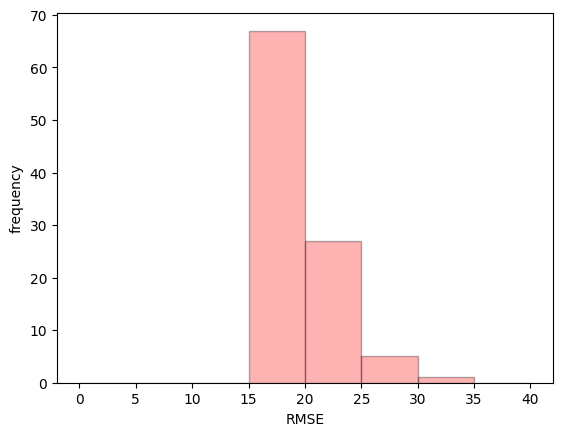

RMSE AVG = 19.93502065393352, RMSE STD = 2.313585341871282
Residual AVG = -0.8362096672078968, Residual STD = 20.051395936426616
stat: 8338.952736686151, p_value: 0.0
Skew: 0.3571050228051442, Kurtosis: 7.355292560930723


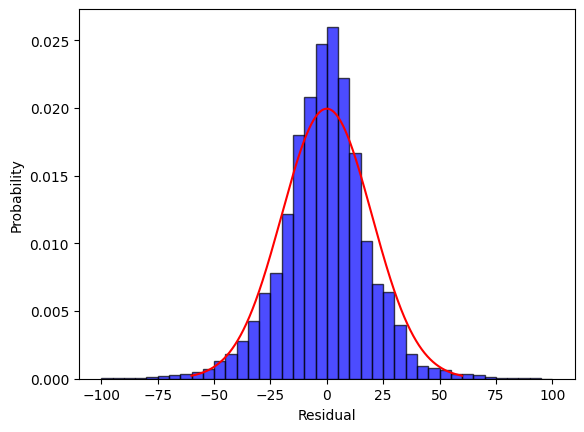

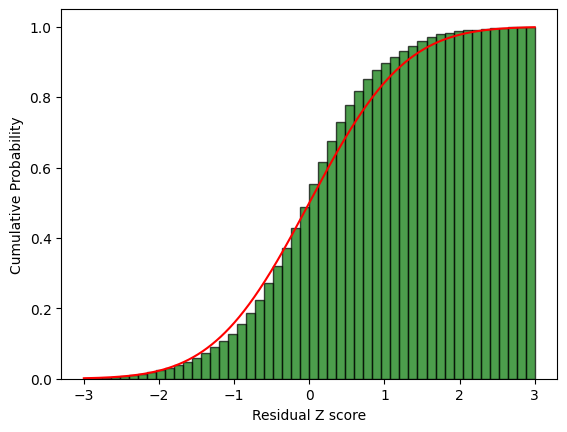

In [40]:
if __name__ == "__main__":
    nodes = 60
    times = 100
    level_config_1 = (1.0, 2.0)
    level_config_2 = (2, 3)
    datasets = handle_datasets(train_split=0.8, show_fig=False)
    # Random int without repetition
    random_list = random.sample(range(0, 2**32 - 1), times)
    all_rmse = []
    all_residual = np.array([])
    for i in range(len(random_list)):
        # option 0: compare with previous price difference, option 1: compare with price going up or down predicitons
        res = train(datasets, nodes=nodes, random_state=random_list[i], show_fig=False, threshold_opt=1, level_config=level_config_1)
        print(f"finish model {i}")
        all_rmse.append(res["RMSE"])
        all_residual = np.append(all_residual, res["residual"])
    plt.clf()
    plt.hist(all_rmse, bins=8, range=(0, 40), facecolor="red", edgecolor="black", alpha=0.3)
    plt.xlabel("RMSE")
    plt.ylabel("frequency")
    plt.show(block=False)
    rmse_avg = np.mean(all_rmse)
    rmse_std = np.std(all_rmse)
    print(f"RMSE AVG = {rmse_avg}, RMSE STD = {rmse_std}")
    res_avg = np.mean(all_residual)
    res_std = np.std(all_residual)
    print(f"Residual AVG = {res_avg}, Residual STD = {res_std}")
    # Normal distribution Test
    test_result = stats.normaltest(all_residual)
    print(f"stat: {test_result.statistic}, p_value: {test_result.pvalue}")
    print(f"Skew: {stats.skew(all_residual)}, Kurtosis: {stats.kurtosis(all_residual)}")
    # np.histogram 取誤差範圍 range=-200~200, bins=? 分?組
    hist,bins = np.histogram(a=all_residual,bins=10,range=(-200,200),density=False)
    plt.clf()
    # 顯示常態分佈曲線
    mu = 0
    sigma = 20
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 10000)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color="#FF0000")
    # 取誤差範圍 range=-200~200, bins=80 分80組 每組差5, density=True 回傳機率而非次數
    plt.hist(all_residual, bins=40, range=(-100,100), facecolor="blue", edgecolor="black", alpha=0.7, density=True)
    plt.xlabel("Residual")
    plt.ylabel("Probability")
    plt.show()
    # 顯示z score分佈曲線

    mu = 0
    sigma = 1
    z_residual = stats.zscore(all_residual)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 10000)
    plt.plot(x, stats.norm.cdf(x, mu, sigma), color="#FF0000")
    plt.hist(z_residual, bins=50, range=(-3,3), facecolor="#007500", edgecolor="black", alpha=0.7, density=True, cumulative=True)
    plt.xlabel("Residual Z score")
    plt.ylabel("Cumulative Probability")
    plt.show()

In [21]:
# add z score function
import numpy as np
a = np.array([ 1,2,3])
stats.zscore(a)

array([-1.22474487,  0.        ,  1.22474487])

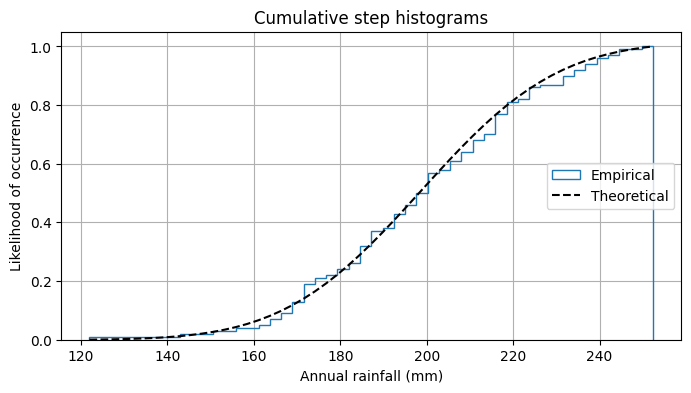

In [35]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)

mu = 200
sigma = 25
n_bins = 50
x = np.random.normal(mu, sigma, size=100)

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(x, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical')

# Add a line showing the expected distribution.
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
y = y.cumsum()
y /= y[-1]

ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')

# Overlay a reversed cumulative histogram.
# ax.hist(x, bins=bins, density=True, histtype='step', cumulative=-1,
#         label='Reversed emp.')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('Annual rainfall (mm)')
ax.set_ylabel('Likelihood of occurrence')

plt.show()